In [9]:
# Execute only once.

import os
# # Change working directory = uncertainties folder
# os.chdir(os.path.dirname(os.getcwd()))
print('Working directory: {}'.format(os.getcwd()))

import sys
sys.path.insert(0, os.getcwd())
sys.path.insert(0, '/usr/local/google/home/rikel/Desktop/rik/projects/nicolas_brosse/code/uncertainties/')

Working directory: /usr/local/google/home/rikel/Desktop/rik/projects/nicolas_brosse/code/uncertainties/notebooks


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle 
import keras

/usr/local/google/home/rikel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
from utils.metrics import *

In [3]:
# Load y datasets, one-hot encoding
(_,_), (_,y_mnist) = keras.datasets.mnist.load_data()
(_,_), (_,y_cifar10) = keras.datasets.cifar10.load_data()
(_,_), (_,y_cifar100) = keras.datasets.cifar100.load_data()

y_mnist = keras.utils.to_categorical(y_mnist, 10)
y_cifar10 = keras.utils.to_categorical(y_cifar10, 10)
y_cifar100 = keras.utils.to_categorical(y_cifar100, 100)

In [14]:
file_mnist_boot = '/usr/local/google/home/rikel/Desktop/rik/projects/nicolas_brosse/code/mnist-outputs-data/mnist-first-10_bootstrap_ep-10_lr-0.1_bs-32_s-100/p_in.h5'

met = metrics_from_h5file(y_mnist, h5file=file_mnist_boot)

----------------
Reading file /usr/local/google/home/rikel/Desktop/rik/projects/nicolas_brosse/code/mnist-outputs-data/mnist-first-10_bootstrap_ep-10_lr-0.1_bs-32_s-100/p_in.h5 divided in 1 chunks.
----------------


In [18]:
met.keys()

dict_keys(['acc', 'bs', 'p_mean', 'p_std', 'neglog', 'ent', 'cal', 'q_tab', 'ent_q', 'mi', 'risk_cov_std', 'risk_cov_softmax', 'risk_cov_q'])

In [20]:
met['p_std'].shape, met['p_mean'].shape, met['q_tab'].shape

((10000, 10), (10000, 10), (10000, 10))

In [69]:
def compute_risk_coverage(points):
    # points is a matrix; first column is whether the point was correctly classified (1) or not (0)
    # second column contains the value of the confidence function
    
    # sort by decreasing value of confidence
    n = points.shape[0]
    points = points[(-points[:, 1]).argsort()]
    sum_accuracy = np.cumsum(points[:, 0])
    return [((i+1)/n, float(acc) / (i+1)) for i, acc in enumerate(sum_accuracy)]

In [70]:
points_acc = (np.argmax(y_mnist, axis=1) == np.argmax(met['p_mean'], axis=1)).astype(int)

In [71]:
np.mean(points_acc)

0.9812

In [72]:
points_pmax = np.hstack([points_acc[:, np.newaxis],
                         np.max(met['p_mean'], axis=1, keepdims=True)])

In [73]:
points_pstd = np.hstack([points_acc[:, np.newaxis],
                         np.max(-met['p_std'], axis=1, keepdims=True)])

In [74]:
points_qtab = np.hstack([points_acc[:, np.newaxis],
                         np.max(met['q_tab'], axis=1, keepdims=True)])

In [75]:
rc_pmax = compute_risk_coverage(points_pmax)

In [76]:
rc_pstd = compute_risk_coverage(points_pstd)

In [77]:
rc_qtab = compute_risk_coverage(points_qtab)

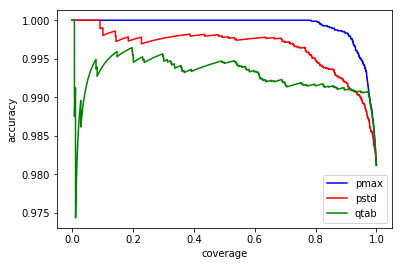

In [174]:
plt.plot([elt[0] for elt in rc_pmax], [elt[1] for elt in rc_pmax], 'b', label='pmax')
plt.plot([elt[0] for elt in rc_pstd], [elt[1] for elt in rc_pstd], 'r', label='pstd')
plt.plot([elt[0] for elt in rc_qtab], [elt[1] for elt in rc_qtab], 'g', label='qtab')
plt.xlabel('coverage')
plt.ylabel('accuracy')
plt.legend(loc="best")
# plt.ylim((0, 1))

In [81]:
def find_best_coverage(max_risk, risk_coverage_curve):
    min_acc = 1 - max_risk
    for cov, acc in risk_coverage_curve[::-1]:
        if acc > min_acc:
            return cov
    return -1

In [112]:
max_risk = 0.001

In [133]:
find_best_coverage(max_risk, rc_pmax)

0.8531

In [134]:
find_best_coverage(max_risk, rc_pstd)

0.1014

In [135]:
find_best_coverage(max_risk, rc_qtab)

0.0079

In [149]:
param_int = np.linspace(0., 1., 10)

In [166]:
vals = {} ; validation_split = 0.5
for a in param_int:
    for b in param_int:
        for c in param_int:
            # compute new confidence function
            conf_f = a * np.max(met['p_mean'], axis=1, keepdims=True)
            conf_f += b * np.max(-met['p_std'], axis=1, keepdims=True)
            conf_f += c * np.max(met['q_tab'], axis=1, keepdims=True)
            points_conf_f = np.hstack([points_acc[:, np.newaxis], conf_f])
            
            # split points in validation and test
            points_val = int(validation_split * points_conf_f.shape[0])
            points_conf_val = points_conf_f[:points_val, :]
            points_conf_test = points_conf_f[points_val:, :]
            
            # compute risk coverage, and maximum coverage for given risk
            rc_conf_val = compute_risk_coverage(points_conf_val)
            bc_conf_val = find_best_coverage(max_risk, rc_conf_val)            
            rc_conf_test = compute_risk_coverage(points_conf_test)
            bc_conf_test = find_best_coverage(max_risk, rc_conf_test)            
            
            vals[(a, b, c)] = (bc_conf_val, bc_conf_test, rc_conf_val, rc_conf_test)
            # print(a, b, c, bc_conf_val, bc_conf_test)

In [167]:
a_opt, b_opt, c_opt = -1, -1, -1
cov_opt = 0

for key, val in vals.items():
    if a_opt == -1 or val[0] > cov_opt:
        a_opt, b_opt, c_opt = key
        cov_opt = val[0]

In [168]:
a_opt, b_opt, c_opt, cov_opt

(0.7777777777777777, 0.0, 0.6666666666666666, 0.766)

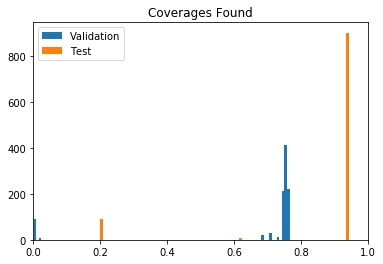

In [177]:
plt.hist([val[0] for key, val in vals.items()], bins=100, label='Validation')
plt.hist([val[1] for key, val in vals.items()], bins=100, label='Test')
plt.title('Coverages Found')
plt.legend(loc="best")
plt.xlim((0, 1))
plt.show()

Text(0.5,1,'Validation Performance')

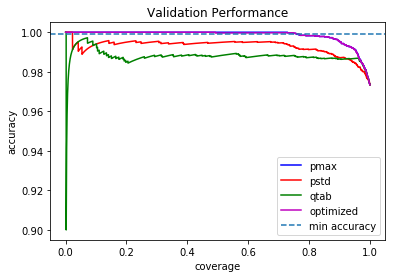

In [169]:
plt.plot([elt[0] for elt in vals[1.0, 0.0, 0.0][2]],
         [elt[1] for elt in vals[1.0, 0.0, 0.0][2]], 'b', label='pmax')
plt.plot([elt[0] for elt in vals[0.0, 1.0, 0.0][2]],
         [elt[1] for elt in vals[0.0, 1.0, 0.0][2]], 'r', label='pstd')
plt.plot([elt[0] for elt in vals[0.0, 0.0, 1.0][2]],
         [elt[1] for elt in vals[0.0, 0.0, 1.0][2]], 'g', label='qtab')
plt.plot([elt[0] for elt in vals[a_opt, b_opt, c_opt][2]],
         [elt[1] for elt in vals[a_opt, b_opt, c_opt][2]], 'm', label='optimized')
plt.axhline(1-max_risk, ls='--', label='min accuracy')
plt.xlabel('coverage')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.title('Validation Performance')

Text(0.5,1,'Test Performance')

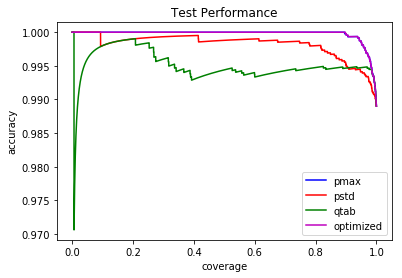

In [170]:
plt.plot([elt[0] for elt in vals[1.0, 0.0, 0.0][3]],
         [elt[1] for elt in vals[1.0, 0.0, 0.0][3]], 'b', label='pmax')
plt.plot([elt[0] for elt in vals[0.0, 1.0, 0.0][3]],
         [elt[1] for elt in vals[0.0, 1.0, 0.0][3]], 'r', label='pstd')
plt.plot([elt[0] for elt in vals[0.0, 0.0, 1.0][3]],
         [elt[1] for elt in vals[0.0, 0.0, 1.0][3]], 'g', label='qtab')
plt.plot([elt[0] for elt in vals[a_opt, b_opt, c_opt][3]],
         [elt[1] for elt in vals[a_opt, b_opt, c_opt][3]], 'm', label='optimized')
plt.xlabel('coverage')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.title('Test Performance')